In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

In [4]:
sessions

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,...,experiment,ncore,ncore_active,nhost,npilot,npilot_active,nunit,nunit_done,nunit_failed,sid
rp.session.one.mturilli.017238.0010,170.7280,300.9957,20.9700,0.0014,0.0995,498.7787,192.7822,0.0018,0.0254,0.0031,...,exp1,4,4,1,1,1,4,4,0,rp.session.one.mturilli.017238.0010
rp.session.one.mturilli.017238.0011,216.4666,995.4985,19.6736,0.0015,0.5830,1239.1304,703.6297,0.1965,9.2674,1.2793,...,exp1,1024,1024,1,1,1,1024,1004,20,rp.session.one.mturilli.017238.0011
rp.session.one.mturilli.017238.0012,214.2963,802.3451,20.4641,0.0013,0.5662,1071.7852,703.4815,0.1973,9.1209,1.2956,...,exp1,1024,1024,1,1,1,1024,1004,20,rp.session.one.mturilli.017238.0012


In [5]:
pilots

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,experiment,hid,ncore,nunit,pid,sid
0,170.7280,300.9957,20.9700,0.0014,0.0995,exp1,smic229.204.90.41.229,4,4,pilot.0000,rp.session.one.mturilli.017238.0010
1,216.4666,995.4985,19.6736,0.0015,0.5830,exp1,smic160.204.90.41.160,1024,1024,pilot.0000,rp.session.one.mturilli.017238.0011
2,214.2963,802.3451,20.4641,0.0013,0.5662,exp1,smic033.204.90.41.33,1024,1024,pilot.0000,rp.session.one.mturilli.017238.0012


In [6]:
units

,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,U_UMGR_BINDING,U_UMGR_SCHEDULING,experiment,hid,pid,sid,uid
0,192.7569,0.0018,0.0231,0.0031,0.0015,0.1036,exp1,smic229.204.90.41.229,pilot.0000,rp.session.one.mturilli.017238.0010,unit.000000
1,192.7808,0.0018,0.0009,0.0008,0.0015,0.1026,exp1,smic229.204.90.41.229,pilot.0000,rp.session.one.mturilli.017238.0010,unit.000001
2,191.7698,0.0018,0.0092,0.0015,0.0015,0.1016,exp1,smic229.204.90.41.229,pilot.0000,rp.session.one.mturilli.017238.0010,unit.000002
3,192.7654,0.0018,0.0162,0.0023,0.0015,0.1007,exp1,smic229.204.90.41.229,pilot.0000,rp.session.one.mturilli.017238.0010,unit.000003
4,206.7085,0.1965,8.0695,1.2793,0.1617,2.3962,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000000
5,NaN,0.1965,0.0013,0.0814,0.1617,2.3956,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000001
6,NaN,0.1965,0.0112,0.0823,0.1617,2.3950,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000002
7,NaN,0.1965,0.0200,0.0832,0.1617,2.3944,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000003
8,NaN,0.1965,0.0280,0.0842,0.1617,2.3938,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000004
9,NaN,0.1965,0.0357,0.0851,0.1617,2.3930,exp1,smic160.204.90.41.160,pilot.0000,rp.session.one.mturilli.017238.0011,unit.000005


## Experiment 1

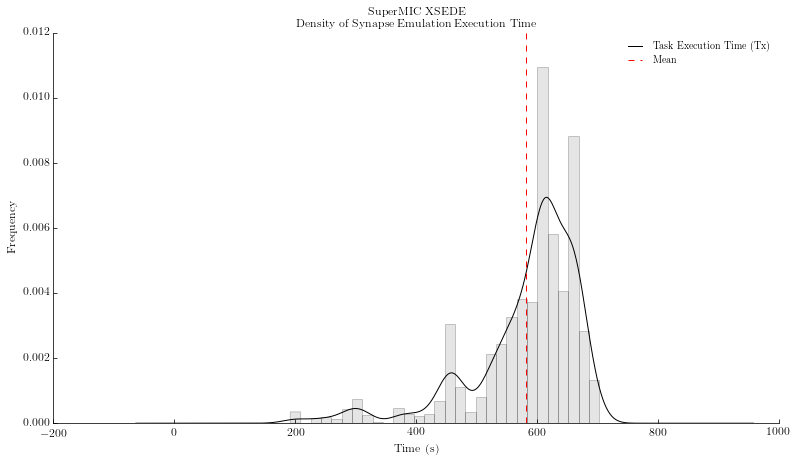

In [9]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
# display(sps.normaltest(units['U_AGENT_EXECUTING'].dropna().tolist()))
units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

plt.xlabel('Time (s)')
ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/supermic_tx_frequency.pdf', dpi=600, bbox_inches='tight')